# Figure 3: Active sampling for cue=0, ecc=0, 12

copied from figure 5 of manuscript 1

## Manuscript Information
 
"Contrast Response Function Estimation with Nonparametric Bayesian Active Learning"  
_Journal of Vision_
https://www.medrxiv.org/content/10.1101/2023.05.11.23289869v1

## Lab and Institution Information

NeuroMedical Informatics Lab  
Washington University in St. Louis

## Figure Description

Display canonical multiple sclerosis phenotype Contrast Sensitivity Function (CSF) curve used in Experiment 1. Train 100 iterations of Gaussian Process machine learning with active learning stimulus selection on simulated data to calculate a Contrast Response Function (CRF).

## References

Kalloniatis, Michael, and Charles Luu. “Visual Acuity.” In _Webvision: The Organization of the Retina and Visual System_, edited by Helga Kolb, Eduardo Fernandez, and Ralph Nelson. Salt Lake City (UT): University of Utah Health Sciences Center, 1995. http://www.ncbi.nlm.nih.gov/books/NBK11509/.


In [10]:
# Import libraries
import os
import sys
import torch as pt
import gpytorch as gp
from utility.utils import *

import math
import numpy as np

import json
import datetime

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.gridspec import GridSpec
import seaborn as sns

# need access to root directory to import utils
parent_dir = os.path.dirname(os.path.abspath(''))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

import scipy.io # JIGO

The variables for Jigo data

In [11]:
# JIGO
# 10 parameters of the data
DUMMY = 0 # 1, 2, 3… 10378
TILT = 1 # 1, -1
CUES = 2 # 1, 0
ECC = 3 # 0, 3, 6, 12
LOC = 4 # 1, -1
SF = 5 # 0.5, 1, 2, 4, 8, 11
CS = 6 # (0, 1], with NaN
ACC = 7 # 0, 1, NaN
TRIALIDX = 8 # 0, 1
CONDITION = 9 # 0

names = ['AB', 'AF', 'AS', 'LH', 'LS', 'MJ', 'RF', 'SC', 'SX']
sfs = [0.5, 1, 2, 4, 8, 11]
eccs = [0, 3, 6, 12]

cues = [0]
eccs = [0, 12]

Check versions of python, Gpytorch, and Pytorch dependencies

In [12]:
print("python version -->>", sys.version)
print("gpytorch version -->>", gp.__version__)
print("pytorch version -->>", pt.__version__)

python version -->> 3.10.4 (v3.10.4:9d38120e33, Mar 23 2022, 17:29:05) [Clang 13.0.0 (clang-1300.0.29.30)]
gpytorch version -->> 1.10
pytorch version -->> 2.0.0


This code was written for

- python version 3.10.9
- pytorch version 1.13.1
- gpytorch version 1.8.1

In [13]:
# Run-time flags

verb_mode = True           # print verbose analyses?
scrn_mode = True           # plot on screen?
save_mode = True           # save plots in indicated directory?

# Fig A
plot_a_canon = True          # plot canonical CSF spline-interpolated curves?
plot_a_prior  = True         # plot GP posterior mean?
plot_a_thresh  = True        # plot 50% threshold curve of GP posterior mean? # JIGO: 75%
plot_a_data = True           # plot actively learned data?

# Fig B
plot_b_rmse = True           # plot Root Mean Square Error of GP CSF estimation?
plot_b_canon = True          # plot canonical CSF spline-interpolated curves?
plot_b_thresh = True         # plot 50% threshold curve of prior? # JIGO: 75%

# Fig C
plot_c_cdf = True            # plot the Cumulative Density Function 
plot_c_canonical = True

# Choose the raw frequency for Figure C
raw_freq_to_slice_at = 4     # cycles per degree
freq_to_slice_at = logFreq().forward(raw_freq_to_slice_at)

# dir to save to
# save_dir = 'analysis/figure_05/' 
save_dir = 'Jigo_analysis/figure_03/' # JIGO

# Save RMSE to text file
save_rmse = True
rmse_txt_path = f'{save_dir}JIGO_rmses.txt'

# Individual print flags 
print_training_hyperparameters = False 
print_training_iters = False
print_progress_bar = False

# Set all to true if verb_mode
if verb_mode:
    print_training_hyperparameters = True
    print_training_iters = True
    print_progress_bar = False

In [14]:
# Constant Declarations

# Fix random seed
generative_random_seed = 1

'''
# Which phenotypes are you considering?
# Store list of all Current phenos

data_dir = 'data/raw_data/'
data_file_name = 'csf_curves_exp1.json'
data_file_path = f'{data_dir}{data_file_name}'

csf_curves_exp1 = load_json_from_file(data_file_path)

all_phenos= {'MS'   : ('Multiple Sclerosis', csf_curves_exp1['multiple_sclerosis']),
             'Cat'  : ('Cataracts', csf_curves_exp1['cataracts']),
             'Norm' : ('Normal', csf_curves_exp1['normal']),
             'MA'   : ('Mild Amblyopia', csf_curves_exp1['mild_amblyopia'])}

# Which phenotypes are you considering among 'MS', 'Cat', 'Norm' and 'MA'?
calc_phenos = ['MS'] # should be same as filename
phenos = [all_phenos[pheno] for pheno in calc_phenos]
'''

# Which phenotypes are you considering?
# Store list of all Current phenos

# JIGO
data_dir = 'data/Jigo_thresh_data/'
data_file_name = 'four_D_thresh.mat'
data_file_path = f'{data_dir}{data_file_name}'
mat_data = scipy.io.loadmat(data_file_path)
Jigo_4D_thresh = mat_data['cs']


def get_Jigo_thresh(name='LS', cue=0, ecc=0):
    name_idx = names.index(name)
    ecc_idx = int(ecc/3)
    if ecc_idx == 4:
        ecc_idx -= 1 # these three lines enable correct ecc_idx
    thresh = logContrast().forward(1/Jigo_4D_thresh[name_idx, cue, :, ecc_idx])
    freq = logFreq().forward(np.array(sfs))
    Jigo_thresh_points = np.vstack((freq, thresh)).T
    return Jigo_thresh_points
    
    
# Prior raw bounds
# prior_raw_freq_min = 0.5
# prior_raw_freq_max = 64
prior_raw_freq_min = 0.125
prior_raw_freq_max = 32 # JIGO
prior_raw_contrast_min = 1e-3
prior_raw_contrast_max = 1

# Prior bounds
prior_freq_min = logFreq().forward(prior_raw_freq_min)
prior_freq_max = logFreq().forward(prior_raw_freq_max)
prior_contrast_sensitivity_min = logContrast().forward(prior_raw_contrast_max)  # inverting-->max&min flipped 
prior_contrast_sensitivity_max = logContrast().forward(prior_raw_contrast_min)

# Create the bounds for the data
# raw_freq_min = 1
# raw_freq_max = 64
raw_freq_min = 0.5
raw_freq_max = 16 # JIGO
raw_contrast_min = 1e-3
raw_contrast_max = 1

# Define how to transform the data
x_min = logFreq().forward(raw_freq_min)
x_max = logFreq().forward(raw_freq_max)
y_min = logContrast().forward(raw_contrast_max)  # max and min get flipped when inverting
y_max = logContrast().forward(raw_contrast_min)

# transform the data
def normalize_to_unit_range(d):
    return scale_data_within_range(d, (0, 1), prior_freq_min, prior_freq_max, \
                                   prior_contrast_sensitivity_min, prior_contrast_sensitivity_max)

# marginal log resolutions of evaulation grid
x_resolution = 15  # 15 spatial frequencies per octave
y_resolution = 30  # 30 contrast units per decade

# for computing the proper prior threshold curve
psi_gamma  = 0.04  # guess rate is 4%
psi_lambda = 0.04  # lapse rate is 4%
psi_sigma = .08
sigmoid_type = 'logistic'

# training parameters?
num_halton_samples = 8
num_initial_points_training_iters = 500
num_new_points = 16
num_new_points_training_iters = 150
train_on_all_points_iters = 1500
sampling_strategy = 'active'
mean_module = 'constant_mean'
train_on_all_points_after_sampling = False
calculate_posterior = True
calculate_entropy = True

'''
# Set raw ghost points 
raw_ghost_frequency = np.array([1, 2, 4, 8, 16, 32, 64, 128])
raw_ghost_contrast = np.array([5e-4, 5e-4, 5e-4, 5e-4, 5e-4, 5e-4, 5e-4, 1])
'''
# Set raw ghost points # JIGO
raw_ghost_frequency = np.array([0.5, 1, 2, 4, 8, 16, 32, 64])
raw_ghost_contrast = np.array([5e-4, 5e-4, 5e-4, 5e-4, 5e-4, 5e-4, 5e-4, 1])

# GP hyperparameters?
learning_rate = .125
beta_for_regularization = .25
min_lengthscale = .15 # Note this changed from .2 # need to specify for JIGO?

In [15]:
# Standard plotting Parameters

###########
# GENERAL #
###########

fig_width = 6     # inches
fig_height = 4.5  # inches

dpi_val = 600              # graphics resolution
plt.rcParams['font.family'] = 'Arial'

# Figure A size is 9 by 7 inches, Figure B and Figure C are 3 by 3 inches.
fig_a_size = (9,7)
fig_b_size = (3,3)
fig_c_size = (3,3)

# Composite figure size and configuration
figure_width = 13
figure_height = 6
num_plot_rows = 5
num_plot_columns = 2

# tick settings
axis_tick_params = {
    'axis':'both', 
    'which':'major', 
    'direction':'out'
}

# for "A", "B", "C" labels
subplot_label_font_size = 16
a_subplot_coords = (0.07, 0.89)
b_subplot_coords = (0.56, 0.89)
c_subplot_coords = (0.56, 0.45)


# Colorblind friendly palette	
colors = sns.color_palette('colorblind', n_colors=12)  # colorblind friendly palette
col1=0; col2=1; col3=2; col4=4

legend_font_size = 8
legend_font_weight = 'roman'
tick_font_size = 10
tick_font_weight = 'roman'
label_font_size = 12
label_font_weight = 'roman'
title_font_size = 14
title_font_weight = 'roman'
suptitle_font_size = 16
suptitle_font_weight = 'roman'


##########
# PLOT A #
##########

# plotting order -- higher on top
success_zorder = 5
fail_zorder = 4
thresh_zorder = 3
canon_zorder = 2
posterior_zorder = 1

# colors
a_latent_color = '#cf30cf'
a_mean_color = '#40E1D0'
success_color = 'blue'
failure_color = 'red'

# posterior
fig_a_cb_ticks = [0, .25, .5, .75, 1]
fig_a_cb_labs = [str(tick) for tick in fig_a_cb_ticks]
fig_a_cb_pad = .06
fig_a_cb_label_pad = -55
fig_a_cb_label = 'Detection Probability'
a_prior_color_gradient = 'gist_gray'
a_prior_grad_min = 0
a_prior_grad_max = 1

# marker dimensions
marker_size= 60            # marker size specified in pts
diamond_line_width = .8        # line width specified in pts
plus_line_width= .8
success_marker = '+'            
diamond_size = .4               # scaling constant
diamond_width = .152            # specified in cycles per degree
diamond_height = .10            # specified in log10(contrast)
diamond_fill_color = 'none'     # specify 'none' for transparent
success_label = 'success'       
failure_label = 'failure'

# threshold
a_linestyle= 'dashed'
a_dash_list = [(0, (10.0, 3.0))]
a_thresh_width = 2
num_curve_points = 1000         # large number of points to create curve  

# Figure A and B xticks and yticks 
# xticks_labels = np.array([1, 4, 16, 64])
xticks_labels = np.array([0.5, 1, 2, 4, 8, 16]) # JIGO
yticks_labels = np.array([1, 0.1, 0.01, 0.001])
xticks_values = logFreq().forward(xticks_labels)
yticks_values = logContrast().forward(yticks_labels)

# save values
a_title  = 'Multiple_Sclerosis'
a_xlab = 'Spatial Frequency (cyc/deg)'
a_ylab = 'Contrast'
a_png_path = f"{save_dir}Figure03_{a_title.replace(' ', '_')}.png"
a_pdf_path = f"{save_dir}Figure03_{a_title.replace(' ', '_')}.pdf"

##########
# PLOT B #
##########

# colors
b_latent_color = 'dimgrey'
b_mean_color = '#40E1D0'

# labels
latent_label = 'ground truth'
mean_label = 'predicted'

# dash and legend
b_dash_tuple = (5.5, 3)
b_legend_location = 'lower left'
b_dash_list = a_dash_list

# rmse 
b_rmse_x_coord = 3.1
b_rmse_y_coord = 2.8

# save values
b_title = 'Threshold'
b_xlab = 'Spatial Frequency (cyc/deg)'
b_ylab = 'Contrast'
b_png_path = f"{save_dir}Figure03_B_{b_title.replace(' ', '_')}.png"
b_pdf_path = f"{save_dir}Figure03_B_{b_title.replace(' ', '_')}.pdf"
b_fig_pad = 0.2
b_bbox_mode = 'tight'

##########
# PLOT C #
##########

# colors
c_latent_color = 'dimgrey'
c_mean_color = '#40E1D0'

# dash and legend
c_dash = 10, 3
c_dash_symbol = '--'

# labels
c_xticks_labels = np.array([1, 0.1, 0.01, 0.001])
c_xticks_values = logContrast().forward(c_xticks_labels)
c_yticks_labels = ['0', '0.25', '0.5', '0.75', '1']
c_yticks_values = np.array([0, .25, .5, .75, 1])

# save values 
c_title = f'Probability at {raw_freq_to_slice_at} cyc/deg'
c_xlab = 'Contrast'
c_ylab = 'Detection Probability'
c_legend_location = 'lower left'
c_png_path = f"{save_dir}Figure03_C_{c_title.replace(' ', '_')}.png"
c_pdf_path = f"{save_dir}Figure03_C_{c_title.replace(' ', '_')}.pdf"

## Perform analysis

In [16]:
# Initial Code executions

# specify the name for the person of interest
name = 'LS' # JIGO

results = dict()


# for i in range(len(phenos)):
#     title, curve = phenos[i]

# JIGO
curve_idx = 0
for cue in cues: 
    for ecc in eccs: 
        
        curve = get_Jigo_thresh(name, cue, ecc) # JIGO
        
        ###################
        # CONSTRUCT CURVE #
        ###################
        set_random_seed(generative_random_seed)

        curve = np.array(curve)
        
        # we do not need to do the following because we have [0.5, 1, 2, 4, 8, 11] as Jigo freq
        '''
        # prepare freqs - turn log10 to log2, and start from 0
        curve[:, 0] = (np.log2(10) * curve[:, 0]) - np.log2(.125)
        '''
        left, right, bottom, top = get_data_bounds(curve)
        cs = create_cubic_spline(curve)

        ###############
        # CREATE GRID #
        ###############

        # Make grid
        grid, xx, yy, xs, ys = create_evaluation_grid_resolution(x_min, x_max, y_min, y_max, \
                                                                x_resolution, y_resolution)

        ###################
        # ACTIVE LEARNING #
        ###################

        # we want the grid as a tensor to pass to get_best_entropy

        # create ghost points
        ghost_x1 = logFreq().forward(raw_ghost_frequency)
        ghost_x2 = logContrast().forward(raw_ghost_contrast)
        assert len(ghost_x1) == len(ghost_x2), "x1 and x2 have diff lengths"

        ghost_X = np.vstack((ghost_x1, ghost_x2)).T
        ghost_y = np.array([0]*len(ghost_x2))

        # create initial data points
        halton_X, halton_y = halton_samples_from_data(xx, yy, cs, psi_gamma, psi_lambda, num_halton_samples, \
                                                    sigmoid_type = sigmoid_type, psi_sigma = psi_sigma)

        # combine ghost and halton sampled points
        initial_Xs = np.vstack((ghost_X, halton_X))
        initial_ys = np.hstack((ghost_y, halton_y))

        # count number of ghost points and initial points
        num_initial_points = len(initial_ys)
        num_ghost_points = len(ghost_y)

        model, likelihood, X, y, rmse_list, entropy_list, posterior_list, _ = sample_and_train_gp(
            cs,
            grid,
            xx,
            yy,
            sampling_strategy= sampling_strategy,
            mean_module_name=mean_module,
            psi_sigma=psi_sigma,
            sigmoid_type=sigmoid_type,
            psi_gamma=psi_gamma,
            psi_lambda=psi_lambda,
            lr=learning_rate,
            num_initial_training_iters=num_initial_points_training_iters,
            num_new_points_training_iters=num_new_points_training_iters,
            num_new_points=num_new_points,
            beta_for_regularization=beta_for_regularization,
            train_on_all_points_after_sampling=train_on_all_points_after_sampling,
            train_on_all_points_iters= train_on_all_points_iters,
            phi=normalize_to_unit_range,
            print_training_hyperparameters=print_training_hyperparameters,
            print_training_iters=print_training_iters,
            progress_bar=print_progress_bar,
            min_lengthscale=min_lengthscale,
            calculate_rmse=(save_rmse or plot_b_rmse),
            calculate_entropy=calculate_entropy,
            calculate_posterior=calculate_posterior,
            initial_Xs=initial_Xs,
            initial_ys=initial_ys,
            num_ghost_points=num_ghost_points,
        )

        #################
        # EVALUATE GRID #
        #################

        # transform evaluation grid so it can be used by GP
        grid_transformed = transform_dataset(grid, phi=normalize_to_unit_range)

        # get the predictions on the eval grid
        zz = evaluate_posterior_mean(model, likelihood, grid_transformed).reshape(xx.shape)
        
        # results[i] = {
        results[curve_idx] = { #JIGO
            'xx': xx,
            'yy': yy,
            'zz': zz,
            'X': X,
            'y': y,
            'left': left,
            'right': right,
            'top': top,
            'bottom': bottom,
            'cs': cs,
            'psi_sigma': psi_sigma,
            'psi_gamma': psi_gamma,
            'psi_lambda': psi_lambda,
            'x_min': x_min,
            'x_max': x_max,
            'y_min': y_min,
            'y_max': y_max,
            'xs': xs,
            'ys': ys,
            'entropy_list': entropy_list,
            'initial_points': num_initial_points,
            'grid': grid,
            'model': model,
            'likelihood': likelihood,
            'f': normalize_to_unit_range,
            'rmse': rmse_list,
            'posterior_list': posterior_list,
        }
        curve_idx += 1


iteration 1/24
kernel 0 variance: 14.847031593322754
kernel 1 outputscale: 5.126288890838623
kernel 1 lengthscale: 0.2150636613368988
iteration 2/24
kernel 0 variance: 17.302377700805664
kernel 1 outputscale: 7.257888317108154
kernel 1 lengthscale: 0.2151351273059845
iteration 3/24
kernel 0 variance: 18.514209747314453
kernel 1 outputscale: 10.839245796203613
kernel 1 lengthscale: 0.21519112586975098
iteration 4/24
kernel 0 variance: 17.922956466674805
kernel 1 outputscale: 9.853841781616211
kernel 1 lengthscale: 0.2151978313922882
iteration 5/24
kernel 0 variance: 17.82044219970703
kernel 1 outputscale: 10.11074161529541
kernel 1 lengthscale: 0.21520742774009705
iteration 6/24


## Plot figure

0.2524589378165892


<Figure size 640x480 with 0 Axes>

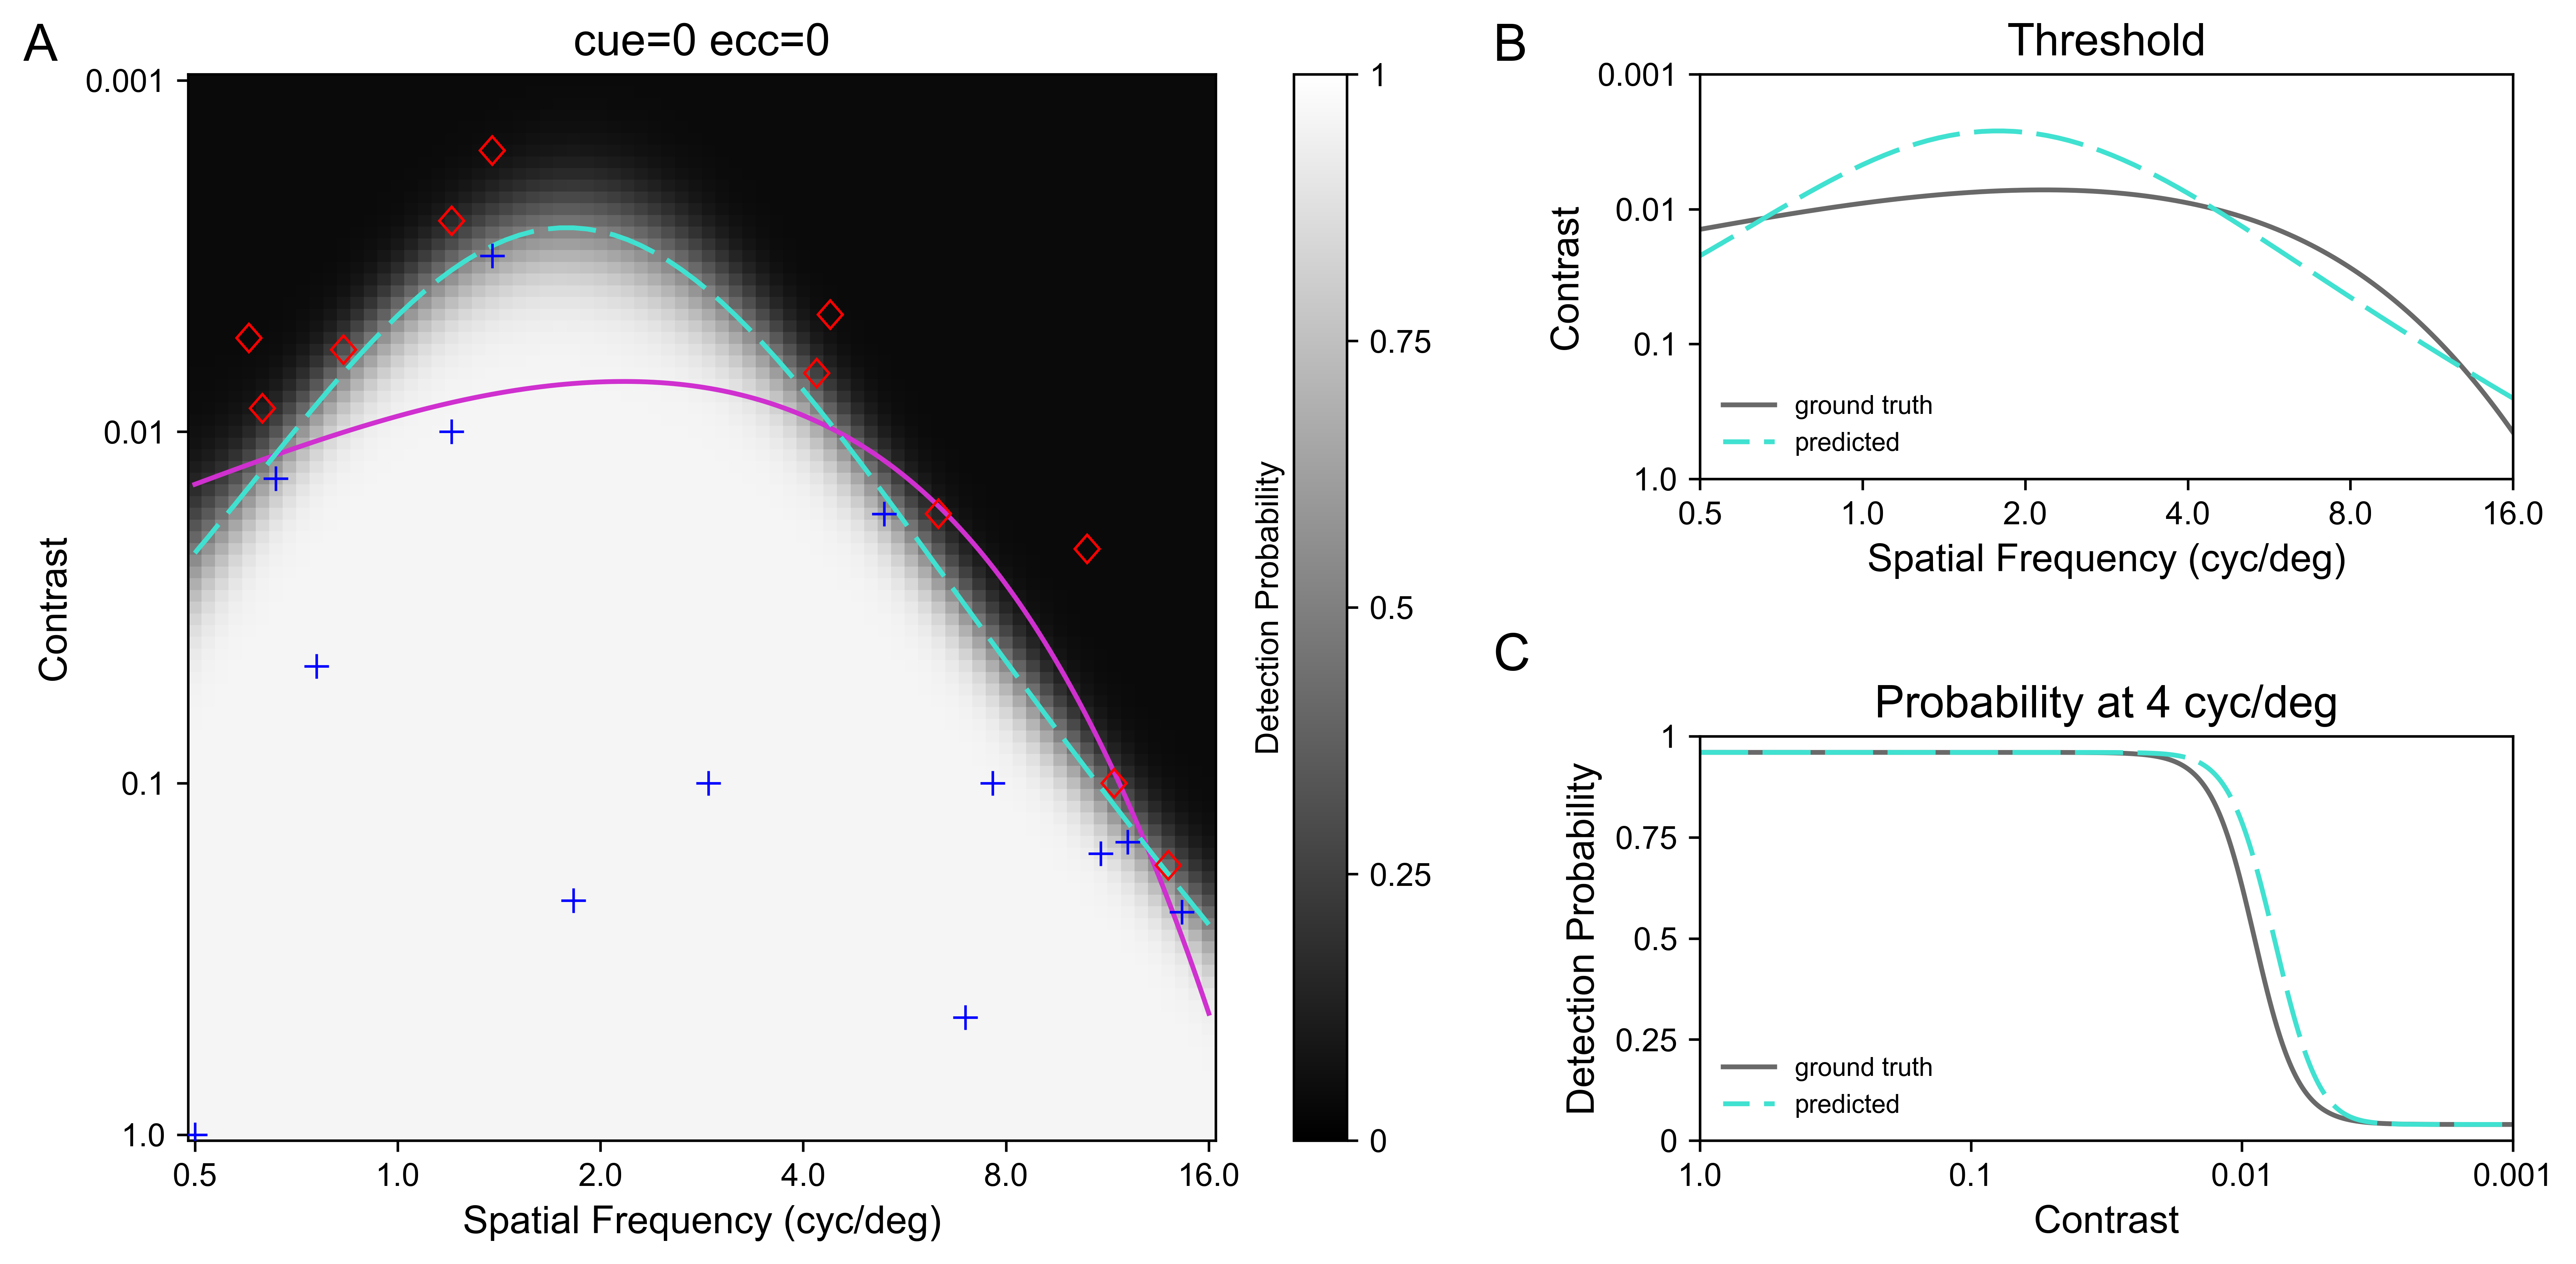

0.3543491497666784


<Figure size 640x480 with 0 Axes>

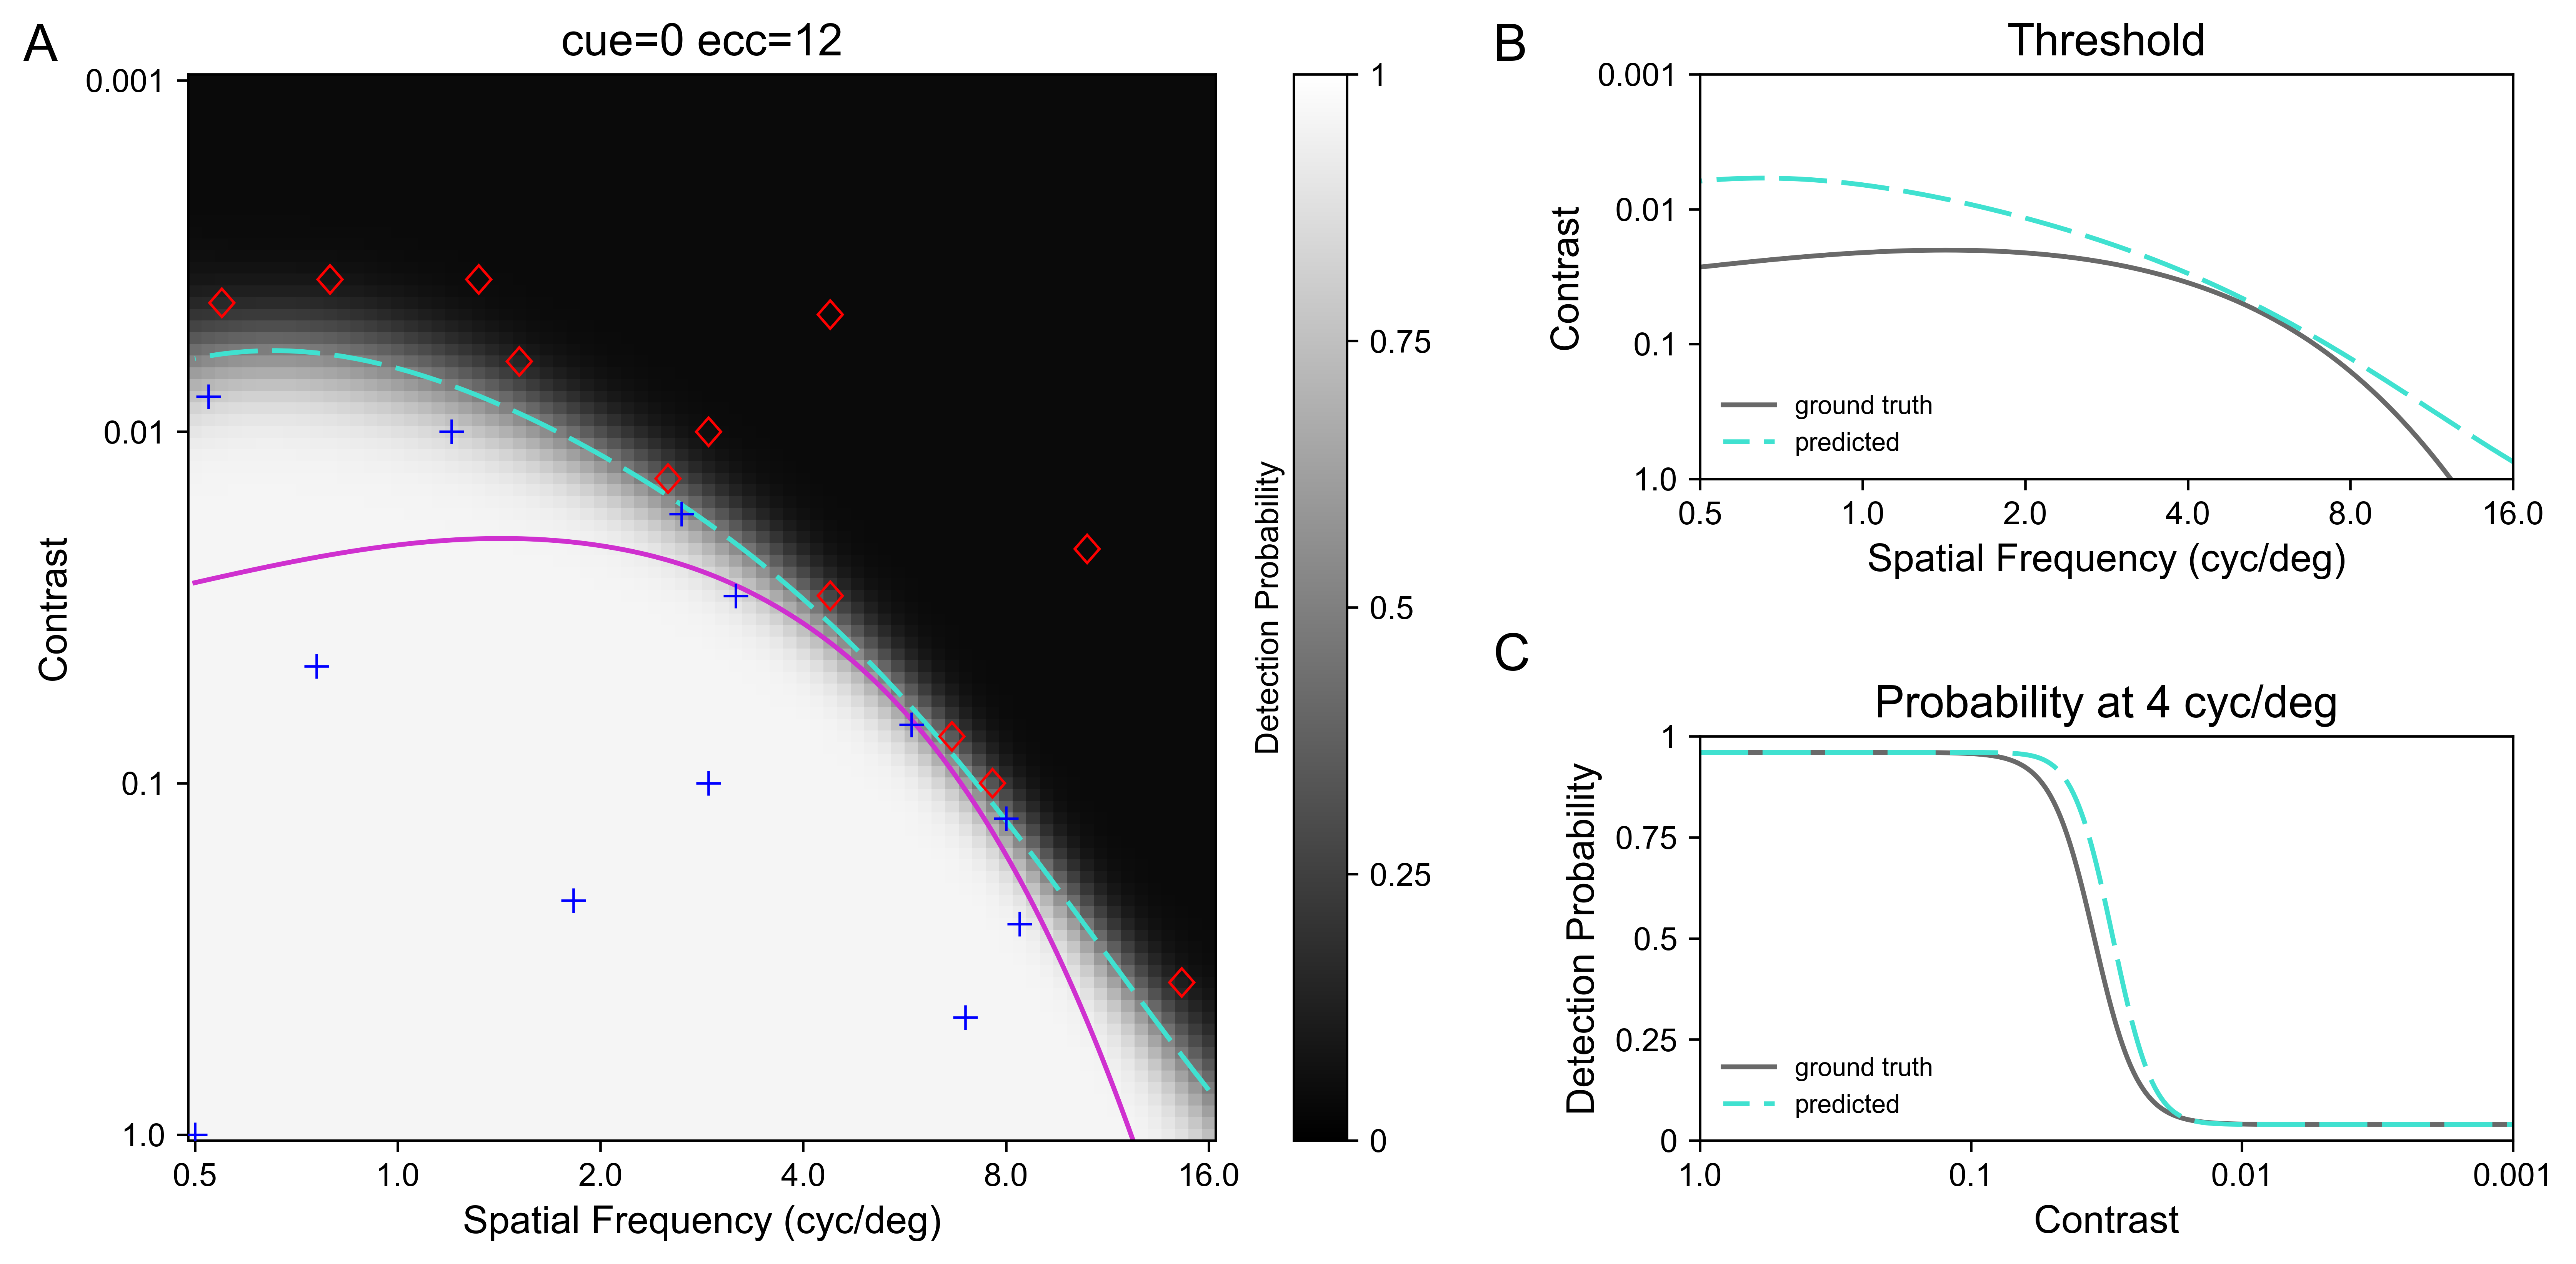

In [ ]:
# this entire block has changed variable names and other content according to JIGO data
Jigo_level = 0.50 # JIGO
%matplotlib inline
plt.tight_layout()

rmse_values = []

# Create a figure and define the grid
fig = plt.figure(figsize=(figure_width, figure_height), dpi=dpi_val)
gs = GridSpec(num_plot_rows, num_plot_columns, width_ratios=[4, 2.5]) 

curve_idx = 0
for cue in cues: 
    for ecc in eccs: 
        
        # test 
        %matplotlib inline
        plt.tight_layout()
        fig = plt.figure(figsize=(figure_width, figure_height), dpi=dpi_val)
        gs = GridSpec(num_plot_rows, num_plot_columns, width_ratios=[4, 2.5])   
        
        ############
        # PLOTTING #
        ############
        
        title = 'cue=' + str(cue) + ' ecc=' + str(ecc)
        results_dict = results[curve_idx]
        
        xx = results_dict['xx']
        yy = results_dict['yy']
        zz = results_dict['zz']
        X = results_dict['X']
        y = results_dict['y']
        left = results_dict['left']
        right = results_dict['right']
        top = results_dict['top']
        bottom = results_dict['bottom']
        cs = results_dict['cs']
        psi_sigma = results_dict['psi_sigma']
        psi_gamma = results_dict['psi_gamma']
        psi_lambda = results_dict['psi_lambda']
        x_min = results_dict['x_min']
        x_max = results_dict['x_max']
        y_min = results_dict['y_min']
        y_max = results_dict['y_max']
        xs = results_dict['xs']
        ys = results_dict['ys']
        entropy_list = results_dict['entropy_list']
        initial_points = results_dict['initial_points']
        grid = results_dict['grid']
        f = results_dict['f']
        posterior_list = results_dict['posterior_list']
        rmse_list = results_dict['rmse']
        
        print(rmse_list[-1])
        rmse = rmse_list[-1]
        
        rmse_values.append(f'{title}: ' + str(rmse_list[-1]))
        
        model = posterior_list[-1][0]
        likelihood = posterior_list[-1][1]
        zz = evaluate_posterior_mean(model, likelihood, grid_transformed).reshape(xx.shape)
        
        ##########
        # PLOT A #
        ##########

        ax1 = plt.subplot(gs[0:num_plot_rows, 0])  # Span all rows in the first column

        # plot the contour field
        if plot_a_prior:
            plt.pcolormesh(xx, yy, zz, cmap=a_prior_color_gradient, vmin=a_prior_grad_min, 
                        vmax=a_prior_grad_max, zorder = posterior_zorder)
            cbar = plt.colorbar(pad=fig_a_cb_pad) 
            cbar.set_ticks(fig_a_cb_ticks)
            cbar.set_ticklabels(fig_a_cb_labs)
            cbar.set_label(fig_a_cb_label, labelpad=fig_a_cb_label_pad)

        # plot the training data
        if plot_a_data:
            x1_failure = X[y == 0, 0].reshape(-1)
            x2_failure = X[y == 0, 1].reshape(-1)
            x1_success = X[y == 1, 0].reshape(-1)
            x2_success = X[y == 1, 1].reshape(-1)
            # Create diamond corner array
            diamond_corners = np.array([
                                    [x1_failure, x2_failure + diamond_height*diamond_size],
                                    [x1_failure + diamond_width*diamond_size, x2_failure],
                                    [x1_failure, x2_failure - diamond_height*diamond_size],
                                    [x1_failure - diamond_width*diamond_size, x2_failure]])
            plt.scatter(x1_success, x2_success, marker =success_marker, s=marker_size, color=success_color, 
                        linewidth=plus_line_width, zorder=success_zorder, label=success_label)
            plt.fill(diamond_corners[:, 0], diamond_corners[:, 1], \
                    color=diamond_fill_color, edgecolor=failure_color, 
                    linewidth=diamond_line_width, zorder= fail_zorder, label = failure_label)

        # plot the canonical CSF
        if plot_a_canon:
            latent_x1 = np.linspace(left, x_max, num_curve_points)
            latent_x2 = cs(latent_x1)
            plt.plot(latent_x1, latent_x2, color=a_latent_color, zorder=canon_zorder)

        # plot the level curve
        if plot_a_thresh:
            level = (1 - psi_lambda + psi_gamma) * Jigo_level # JIGO?
            CS = plt.contour(xx, yy, zz, levels=[level], colors=a_mean_color,
                    linestyles=a_linestyle, zorder=thresh_zorder)

            for c in CS.collections:
                c.set_dashes(a_dash_list)

        # add xticks and yticks and fit to grid
        plt.xticks(xticks_values, xticks_labels)
        plt.yticks(yticks_values, yticks_labels)
        plt.tick_params(**axis_tick_params, labelsize=tick_font_size)
        
        x_padding = (x_max - x_min) / (2 * (xs - 1))
        y_padding = (y_max - y_min) / (2 * (ys - 1))
        plt.xlim(x_min - x_padding, x_max + x_padding)
        plt.ylim(y_min - y_padding, y_max + y_padding)

        # title and axis labels
        plt.title(title, fontsize = title_font_size)
        plt.xlabel(a_xlab, fontsize = label_font_size)
        plt.ylabel(a_ylab, fontsize = label_font_size)

    
        ##########
        # PLOT B #
        ##########
        
        # occupy 1st and 2nd row in 2nd column
        ax2 = plt.subplot(gs[0:math.floor(num_plot_rows/2), 1])  
        
        # plot the spline
        if plot_b_canon:
            latent_x1 = np.linspace(left, x_max, num_curve_points)
            latent_x2 = cs(latent_x1)
            plt.plot(latent_x1, latent_x2, color=b_latent_color)

        # plot the level curve
        if plot_b_thresh:
            level = (1 - psi_lambda + psi_gamma) * Jigo_level
            CS = plt.contour(xx, yy, zz, levels=[level], color=b_mean_color)
            for c in CS.collections:
                c.set_dashes(b_dash_list)
                c.set_edgecolor(b_mean_color)

        # set xticks and yticks and fit to the grid
        plt.xticks(xticks_values, xticks_labels)
        plt.yticks(yticks_values, yticks_labels)
        plt.tick_params(**axis_tick_params, labelsize=tick_font_size)

        # x_padding = (x_max - x_min) / (2 * (xs - 1))
        # y_padding = (y_max - y_min) / (2 * (ys - 1))
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)

        # title, axis labels and legend
        plt.title(b_title, fontsize=title_font_size)
        plt.xlabel(b_xlab, fontsize=label_font_size)
        plt.ylabel(b_ylab, fontsize=label_font_size)

        latent = mlines.Line2D([], [], color=b_latent_color, label=latent_label)
        mean = mlines.Line2D([], [], color=b_mean_color, dashes=b_dash_tuple,
                label=mean_label)
        plt.legend(loc=b_legend_location, fontsize=legend_font_size, handles=[latent, mean], frameon=False)

        ##########
        # PLOT C #
        ##########
        
        ax3 = plt.subplot(gs[math.ceil(num_plot_rows/2):num_plot_rows, 1])  # Occupy last 2 rows in 2nd column

        # create the data set to evaluate
        log_freqs = np.full(num_curve_points, freq_to_slice_at)
        log_contrasts = np.linspace(y_min, y_max, num_curve_points)

        # plot true (simulated) outputs
        if plot_c_canonical:
            sim_outputs = simulate_sigmoid(log_freqs, log_contrasts, cs, psi_gamma, psi_lambda, \
                                        sigmoid_type = sigmoid_type, psi_sigma = psi_sigma)    
            #plot them
            plt.plot(log_contrasts, sim_outputs, color=c_latent_color)

        # plot cdf predicted by GP
        if plot_c_cdf:
            D = np.vstack((log_freqs, log_contrasts)).T
            Dt = transform_dataset(D, phi=f)
            # get the predictions on D
            GP_outputs = evaluate_posterior_mean(model, likelihood, Dt)
            plt.plot(log_contrasts, GP_outputs, color=c_mean_color, linestyle=c_dash_symbol, dashes=c_dash)
        
        ###########
        # GENERAL #
        ###########

        # A, B, and C labels for each subplot
        fig.text(*a_subplot_coords, "A", fontsize=subplot_label_font_size)
        fig.text(*b_subplot_coords, "B", fontsize=subplot_label_font_size)
        fig.text(*c_subplot_coords, "C", fontsize=subplot_label_font_size)

        # Set xticks, yticks and limits
        plt.xticks(c_xticks_values, c_xticks_labels)
        plt.yticks(c_yticks_values, c_yticks_labels)
        plt.tick_params(**axis_tick_params, labelsize=tick_font_size)
        
        plt.xlim(y_min, y_max) # y_lim is for contrast, and here contrast is on the x-axis
        plt.ylim(0, 1) # 0 to 1 for probability
        
        # title, axist labels and legend
        plt.title(c_title, fontsize=title_font_size)
        plt.xlabel(c_xlab, fontsize=label_font_size)
        plt.ylabel(c_ylab, fontsize=label_font_size)
        plt.legend(loc=c_legend_location, fontsize=legend_font_size, handles=[latent, mean], frameon=False)

        # Save fit quality
        if (save_mode and save_rmse):
            ensure_directory_exists(save_dir)
            filename = rmse_txt_path
            with open(filename, 'w') as file:
                for string in rmse_values:
                    file.write(string + '\n')
        curve_idx += 1
        
        # save values
        a_title  = title
        a_xlab = 'Spatial Frequency (cyc/deg)'
        a_ylab = 'Contrast'
        a_png_path = f"{save_dir}Figure03_{a_title.replace('=', '_')}.png"
        a_pdf_path = f"{save_dir}Figure03_{a_title.replace('=', '_')}.pdf"
        
    
        # Show and/or save figure 
        if save_mode:
            ensure_directory_exists(save_dir)
            plt.savefig(a_png_path, bbox_inches='tight', dpi=dpi_val)
            plt.savefig(a_pdf_path, bbox_inches='tight', dpi=dpi_val)
        if scrn_mode:
            plt.show()
        else:
            plt.clf()

In [ ]:
results_object = []
print(results[0]['X'])

for i in range(curve_idx):
    results_object[i] = {'X': results[i]['X'], 'y': results[i]['y']}

    # print(results[i]['X'])
    # print(results[i]['y'])
    # curve_results = dict()
    # curve_results = results[i]['X']
    # # curve_results['y'] = results[i]['y']
    # results_object.append(curve_results)
    
results_dir = 'data/raw_data/'
results_filename = f'results_X03.json'
ensure_directory_exists(results_dir)
with open(results_dir + results_filename, 'w') as file:
    for i in range(curve_idx):
        json.dump(results_object, file, indent=2)

[[ 2.          3.30103   ]
 [ 3.          3.30103   ]
 [ 4.          3.30103   ]
 [ 5.          3.30103   ]
 [ 6.          3.30103   ]
 [ 7.          3.30103   ]
 [ 8.          3.30103   ]
 [ 9.         -0.        ]
 [ 2.          0.        ]
 [ 4.53333333  1.        ]
 [ 3.26666667  2.        ]
 [ 5.8         0.33333333]
 [ 2.6         1.33333333]
 [ 5.13333333  2.33333333]
 [ 3.86666667  0.66666667]
 [ 6.4         1.66666667]
 [ 5.93333333  1.        ]
 [ 2.26666667  2.26666667]
 [ 6.8         0.76666667]
 [ 5.4         1.76666667]
 [ 2.4         1.86666667]
 [ 6.46666667  0.8       ]
 [ 3.46666667  2.5       ]
 [ 3.46666667  2.8       ]
 [ 3.26666667  2.6       ]
 [ 2.33333333  2.06666667]
 [ 6.6         0.83333333]
 [ 2.73333333  2.23333333]
 [ 6.53333333  1.        ]
 [ 5.66666667  1.76666667]
 [ 6.86666667  0.63333333]
 [ 5.06666667  2.16666667]]


IndexError: list assignment index out of range